# Kaggle Intro

In this introductory mission we'll learn how to:

 - Approach a Kaggle competition
 - Explore the competition data and learn about the competition topic
 - Prepare data for machine learning
 - Train a model
 - Measure the accuracy of your model
 - Prepare and make your first Kaggle submission.
 
Kaggle has created a number of competitions designed for beginners. The most popular of these competitions, and the one we'll be looking at, is about predicting [which passengers survived](https://www.kaggle.com/c/titanic/data) the sinking of the Titanic.


In [1]:
import pandas as pd

test = pd.read_csv("test.csv")
test_shape = test.shape

train = pd.read_csv("train.csv")
train_shape = train.shape

## The Data

Below are the descriptions contained in that data dictionary:

 - `PassengerID` - A column added by Kaggle to identify each row and make submissions easier
 - `Survived` - Whether the passenger survived or not and the value we are predicting (`0`=No, `1`=Yes)
 - `Pclass` - The class of the ticket the passenger purchased (`1`=1st, `2`=2nd, `3`=3rd)
 - `Sex` - The passenger's sex
 - `Age` - The passenger's age in years
 - `SibSp` - The number of siblings or spouses the passenger had aboard the Titanic
 - `Parch` - The number of parents or children the passenger had aboard the Titanic
 - `Ticket` - The passenger's ticket number
 - `Fare` - The fare the passenger paid
 - `Cabin` - The passenger's cabin number
 - `Embarked` - The port where the passenger embarked (`C`=Cherbourg, `Q`=Queenstown, `S`=Southampton)

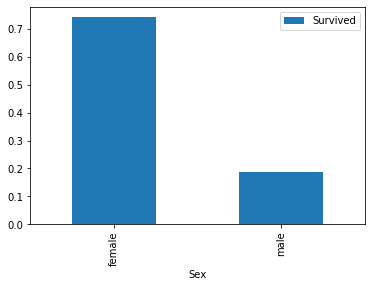

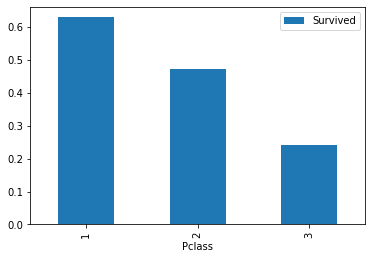

In [2]:
import matplotlib.pyplot as plt

sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()

pclass_pivot = train.pivot_table(index="Pclass",values="Survived")
pclass_pivot.plot.bar()
plt.show()

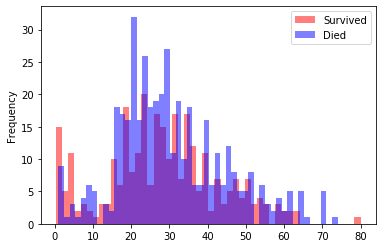

In [3]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

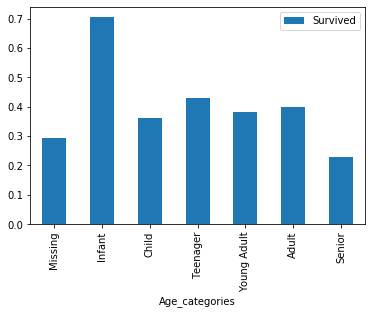

In [6]:
# Exploring and converting the age column

def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]

train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

pivot = train.pivot_table(index="Age_categories",values='Survived')
pivot.plot.bar()
plt.show()

## Prepare Data 

Dummy variables for Sex, Pclass, Age_categories:

In [7]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")

train = create_dummies(train,"Sex")
test = create_dummies(test,"Sex")

train = create_dummies(train,"Age_categories")
test = create_dummies(test,"Age_categories")

## Create 1st ML Model

In [8]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train[columns], train["Survived"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Split Training Data

In [9]:
holdout = test # from now on we will refer to this
               # dataframe as the holdout data

from sklearn.model_selection import train_test_split

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(
    all_X, all_y, test_size=0.20,random_state=0)

## Making Predictions and Measuring their Accuracy


In [10]:
from sklearn.metrics import accuracy_score
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)
print(accuracy)

0.8100558659217877


Our model has an accuracy score of 81.0% when tested against our 20% test set. 

Given that this data set is quite small, there is a good chance that our model is overfitting, and will not perform as well on totally unseen data.

## Using Cross-Validation

In [11]:
from sklearn.model_selection import cross_val_score
import numpy as np
lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = np.mean(scores)
print(scores)
print(accuracy)

[0.8        0.82022472 0.76404494 0.87640449 0.80898876 0.78651685
 0.76404494 0.76404494 0.83146067 0.80898876]
0.8024719101123596


From the results of our k-fold validation, you can see that the accuracy number varies with each fold - ranging between 76.4% and 87.6%. 

This demonstrates why cross validation is important.

In [12]:
# Making predictions on unseen data
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[columns])

## Creating a submission file

In [13]:
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission.csv",index=False)

## Next steps

 - Improving the features:
   - Feature Engineering: Create new features from the existing data.
   - Feature Selection: Select the most relevant features to reduce noise and overfitting.
 - Improving the model:
   - Model Selection: Try a variety of models to improve performance.
   - Hyperparameter Optimization: Optimize the settings within each particular machine learning model.